In [1]:
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm

## Define brain, find trace data folder

In [2]:
#specify brain1 or brain2 below
brain = "brain2"

root_dir = Path(os.path.abspath('')).parents[1]
experiment_dir = os.path.join(root_dir, "axon_geometry")
data_dir = os.path.join(experiment_dir, "data", brain)
segments_swc_dir = os.path.join(data_dir, "segments_swc")
trace_data_dir = os.path.join(data_dir, "trace_data")
trace_data_dir = os.path.join(trace_data_dir, "14")
print(f"Directory where swcs reside: {segments_swc_dir}")

Directory where swcs reside: /cis/home/jteneggi/repo/brainlit/experiments/axon_geometry/data/brain2/segments_swc


## Read trace data

In [3]:
max_id = 300


def classify_height(row):
    height = row["height"]
    if height <= 2:
        return height
    else:
        return 3

def numerical_class(row):
    _class = row["class"]
    if _class == "primary":
        return 0
    if _class == "collateral":
        return 1
    if _class == "terminal":
        return 2

df_path = os.path.join(trace_data_dir, "df.csv")
if os.path.exists(df_path):
    df = pd.read_csv(df_path)
else:
    df = pd.DataFrame(columns=["seg_id", "class", "height", "log_seg_length", "measure", "value", "log_value"])
    for i in tqdm(np.arange(0, max_id)):
        i = int(i)
        trace_data_path = os.path.join(trace_data_dir, "{}.npy".format(i))
        if os.path.exists(trace_data_path) is True:
            trace_data = np.load(trace_data_path, allow_pickle=True)

            for node in trace_data:
                seg_length = node["seg_length"]
                height = node["height"]
                _class = node["class"]
                mean_curvature = node["mean_curvature"]
                mean_torsion = node["mean_torsion"]
                
                log_seg_length = np.log10(seg_length)

                log_mean_curvature = np.log10(mean_curvature)
                df = df.append({"seg_id": i, "height": height, "class": _class, "log_seg_length": log_seg_length, "measure": "curvature", "value": mean_curvature, "log_value": log_mean_curvature}, ignore_index=True)

                log_mean_torsion = np.log10(mean_torsion)
                df = df.append({"seg_id": i, "height": height, "class": _class, "log_seg_length": log_seg_length, "measure": "torsion", "value": mean_torsion, "log_value": log_mean_torsion}, ignore_index=True)
    df.to_csv(df_path)
df["class"] = df.apply(numerical_class, axis=1)
df["height_class"] = df.apply(classify_height, axis=1)

# Density of `log` segment lengths as a function of spline class

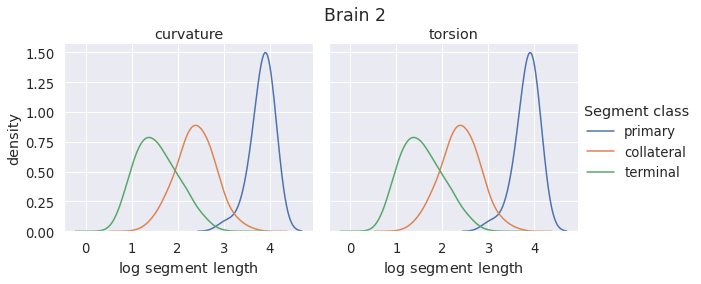

In [4]:
sns.set_theme()
sns.set_context("paper")
sns.set(font_scale=1.2)

g = sns.FacetGrid(df, col="measure", hue="class", height=4)
g.map(sns.kdeplot, "log_seg_length", bw_adjust=1.8)
g.set_axis_labels(r"$\log$ segment length", "density")
g.add_legend(title="Segment class")
legend_labels = ["primary", "collateral", "terminal"]
for t, l in zip(g._legend.texts, legend_labels): t.set_text(l)

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")

axes = g.axes.flatten()
axes[0].set_title("curvature")
axes[1].set_title("torsion")
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_seg_length_class_density.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_seg_length_class_density.jpg"))

# Density of curvature/torsion as a function of spline class

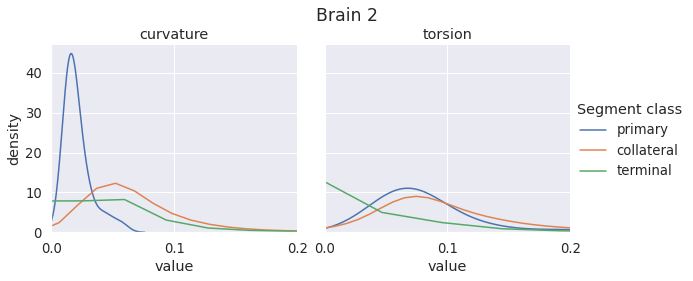

In [5]:
g = sns.FacetGrid(df, col="measure", hue="class", height=4)
g.map(sns.kdeplot, "value", bw_adjust=1.2)

g.set_axis_labels(r"value", "density")

g.add_legend(title="Segment class")
legend_labels = ["primary", "collateral", "terminal"]
for t, l in zip(g._legend.texts, legend_labels): t.set_text(l)
    
#g.set(xlim=[-3, 0], xticks=[-3, -2, -1, 0], yticks=[0, 1, 2, 3])
g.set(xlim=[0, .2], xticks=[0, .1, .2])

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")

axes = g.axes.flatten()
axes[0].set_title("curvature")
axes[1].set_title("torsion")

g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_mean_value_class_density.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_mean_value_class_density.jpg"))

# Evaluate mean and variance of curvature/torsion distributions based on spline class

In [6]:
measures = ["curvature", "torsion"]
class_dict = {0: "primary", 1: "collateral", 2: "terminal"}

for measure in measures:
    measure_df = df[df["measure"] == measure]
    for class_id in class_dict:
        class_name = class_dict[class_id]
        class_values = measure_df[measure_df["class"] == class_id]["value"]
        class_mean = class_values.mean()
        class_var = class_values.var()
        print(f"{class_name} {measure}, mu = {class_mean}, var = {class_var}")

primary curvature, mu = 0.02097013535510928, var = 0.00011866867122445294
collateral curvature, mu = 0.07088719391774903, var = 0.0050942792576704095
terminal curvature, mu = 0.04660007223287369, var = 0.007505070997353336
primary torsion, mu = 0.08344904410601756, var = 0.0022658862117380164
collateral torsion, mu = 0.10474513016589607, var = 0.007533253765838343
terminal torsion, mu = 0.04001322783289919, var = 0.010754557565452233


# Scatter plots of `log` curvature/torsion against `log` segment length as a function of spline class

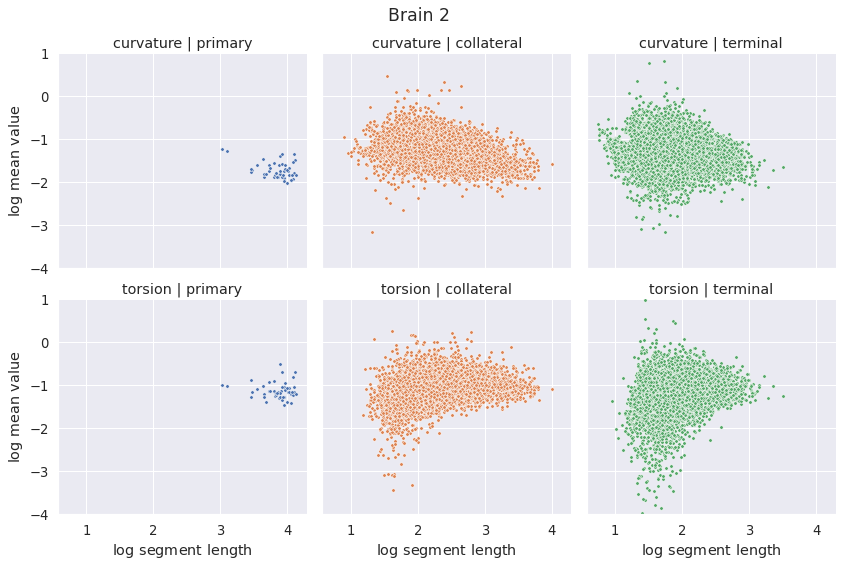

In [7]:
g = sns.FacetGrid(df, row="measure", col="class", hue="class", height=4)
g.map(sns.scatterplot, "log_seg_length", "log_value", marker='.', s=50)
g.set_axis_labels(r"$\log$ segment length", r"$\log$ mean value")
g.set(ylim=[-4, 1])
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Brain 1" if brain=="brain1" else "Brain 2")

axes = g.axes
for i, measure in enumerate(["curvature", "torsion"]):
    for j, _class in enumerate(["primary", "collateral", "terminal"]):
        ax = axes[i, j]
        ax.set_title(f"{measure} | {_class}")
        
g.savefig(os.path.join(experiment_dir, "figures",  f"{brain}_mean_value_class_scatter.eps"))
g.savefig(os.path.join(experiment_dir, "figures", f"{brain}_mean_value_class_scatter.jpg"))